In [137]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from figurefirst import mpl_functions
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable 
import odor_stat_calculations as osc
from scipy.spatial.distance import cdist
import scipy.stats as st
from sklearn.preprocessing import StandardScaler

## training
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:

def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

In [62]:
class MDN(nn.Module):
    def __init__(self, input_size, hidden_dim, n_gaussians):
        super(MDN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim)
        
        # Mixture weights (pi's)
        self.pi = nn.Linear(hidden_dim, n_gaussians)
        
        # Means (mu's)
        self.mu = nn.Linear(hidden_dim, n_gaussians)
        
        # Variances (sigma's)
        self.sigma = nn.Linear(hidden_dim, n_gaussians)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        pi = F.softmax(self.pi(x), dim=1)
        mu = self.mu(x)
        sigma = torch.exp(self.sigma(x))  # Ensure sigma is positive
        
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, target):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    log_prob = m.log_prob(target.unsqueeze(1))
    log_pi = torch.log(pi)
    
    # LogSumExp trick to prevent underflow/overflow
    max_log_prob = log_prob.max(1, keepdim=True)[0]
    log_sum_exp = max_log_prob + torch.log(torch.exp(log_prob - max_log_prob).sum(1, keepdim=True))
    log_likelihood = log_sum_exp + log_pi
    loss = -log_likelihood.sum()
    return loss


def create_sequences(feature_tensors, target_tensors, seq_length):
    sequences = []
    targets = []
    for i in range(len(feature_tensors) - seq_length):
        # Here, make sure each element of sequences is of shape (seq_length, num_features)
        sequences.append(feature_tensors[i:i+seq_length])
        targets.append(target_tensors[i+seq_length])
    return torch.stack(sequences), torch.stack(targets)  # This should be of shape (N, seq_length, num_features)



def load_and_preprocess_file(file_path, features, target):
    df = pd.read_hdf(file_path)
    # df[target] = np.log(df[target] + 1e-6) 
    # df[target] = np.log(np.clip(df[target], a_min=1e-6, a_max=None))

    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])
    
    feature_tensors = torch.Tensor(df[features].values)
    target_tensors = torch.Tensor(df[target].values)

    feature_tensors = feature_tensors.view(-1, len(features))
    return feature_tensors, target_tensors


def predict_on_new_data_mdn(model, file_path, features, target, seq_length, device):
    model.eval()
    feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
    sequences, _ = create_sequences(feature_tensors, target_tensors, seq_length)
    
    with torch.no_grad():
        sequences = sequences.to(device)
        flattened_sequences = sequences.view(sequences.size(0), -1).float()
        pi, mu, sigma = model(flattened_sequences)
        
        # Instead of just computing the expected value, we can also sample from the distribution
        sampled_vals = sample_from_output(pi, mu, sigma, num_samples=100)  # assuming you have defined sample_from_output
        
        # If you still want the expected values, you can calculate them as well
        expected_val = (pi * mu).sum(dim=1).cpu().numpy()
        
    return sampled_vals, expected_val  # return both the samples and the expected value

def sample_from_output(pi, mu, sigma, num_samples):
    """
    Sample from the Gaussian mixture model output by the network.

    Parameters:
        pi (Tensor): Mixture component weights from the network.
        mu (Tensor): Means of the Gaussian components from the network.
        sigma (Tensor): Standard deviations of the Gaussian components from the network.
        num_samples (int): Number of samples to draw from the distribution.

    Returns:
        np.ndarray: An array of shape (batch_size, num_samples) containing the samples.
    """
    # Get the parameters as numpy arrays
    pi_np = pi.cpu().numpy()
    mu_np = mu.cpu().numpy()
    sigma_np = sigma.cpu().numpy()

    # Prepare an array to hold the samples
    samples = np.zeros((pi_np.shape[0], num_samples))

    # For each item in the batch, sample from the distribution
    for i in range(pi_np.shape[0]):
        # Use the probabilities to pick a component, then sample from it
        component = np.random.choice(np.arange(pi_np.shape[1]), p=pi_np[i])
        samples[i, :] = np.random.normal(mu_np[i, component], sigma_np[i, component], num_samples)

    return samples



def train_on_single_file_faster(model, optimizer, sequences, targets, num_epochs, device):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        pi, mu, sigma = model(sequences.view(sequences.size(0), -1))
        loss = mdn_loss(pi, mu, sigma, targets.squeeze())
        
        loss.backward()
        optimizer.step()
        
        # Optional: print epoch and loss
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


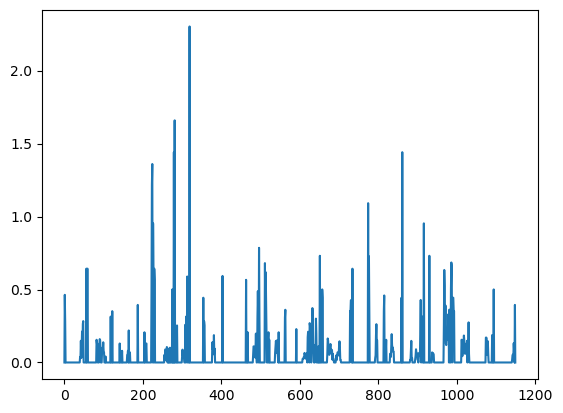

In [61]:
# df = pd.read_hdf(fp)
# # plt.plot(np.log10(df.odor+1))
# # plt.plot(df.odor)
# scaler = MinMaxScaler(feature_range=(1, 10))
# df['odor_scaled'] = scaler.fit_transform(df['odor'].values.reshape(-1, 1))
# # plt.plot(df.odor_scaled)
# plt.plot(np.log(df.odor_scaled))

# # plt.plot(df.distance_along_streakline)
# # plt.plot(df.nearest_from_streakline)
# # scaler = StandardScaler()
# # df[features] = scaler.fit_transform(df[features])
# # plt.plot(df.distance_along_streakline)
# # plt.plot(df.nearest_from_streakline)

In [84]:
input_size = 2  
hidden_dim = 64
num_epochs = 700
seq_length = 7
n_gaussians = 1  # Number of Gaussians in the mixture. Adjust as needed.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_mdn = MDN(input_size = seq_length * 2, hidden_dim = hidden_dim, n_gaussians=n_gaussians).to(device)
optimizer = optim.Adam(model_mdn.parameters(), lr=0.001)

features = ['distance_along_streakline', 'nearest_from_streakline']
target = ['odor']

filepath = "/home/beast/An/data/Sept13Plumes/plume1/train/"

# scaler = StandardScaler()
# features_normalized = scaler.fit_transform(features)


for file in os.listdir(filepath):
    file_path = os.path.join(filepath, file)
    feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
    sequences, targets = create_sequences(feature_tensors, target_tensors, seq_length)
    
    sequences = sequences.to(device)
    targets = targets.to(device)
    
    train_on_single_file_faster(model_mdn, optimizer, sequences, targets, num_epochs, device)


Epoch [100/700], Loss: -1189.0720
Epoch [200/700], Loss: -1513.0183
Epoch [300/700], Loss: -1691.5808
Epoch [400/700], Loss: -1686.9465
Epoch [500/700], Loss: -1913.5254
Epoch [600/700], Loss: -1944.2255
Epoch [700/700], Loss: -2049.8711
Epoch [100/700], Loss: -732.3166
Epoch [200/700], Loss: -903.0117
Epoch [300/700], Loss: -1017.4799
Epoch [400/700], Loss: -1110.8049
Epoch [500/700], Loss: -1194.8364
Epoch [600/700], Loss: -1276.8920
Epoch [700/700], Loss: -1359.3108
Epoch [100/700], Loss: -724.3348
Epoch [200/700], Loss: -793.3651
Epoch [300/700], Loss: -831.4146
Epoch [400/700], Loss: -878.9500
Epoch [500/700], Loss: -916.7369
Epoch [600/700], Loss: -942.0862
Epoch [700/700], Loss: -963.2816
Epoch [100/700], Loss: -2082.8259
Epoch [200/700], Loss: -2483.9460
Epoch [300/700], Loss: -2742.5874
Epoch [400/700], Loss: -2931.4043
Epoch [500/700], Loss: -3072.4358
Epoch [600/700], Loss: -3181.5068
Epoch [700/700], Loss: -3335.2576
Epoch [100/700], Loss: -1769.4575
Epoch [200/700], Loss: 

In [135]:
def predict_modes(model, sequences):
    with torch.no_grad():
        pi, mu, sigma = model(sequences)
        # For each set of predictions, get the index of the distribution with the highest weight
        max_pi_indices = torch.argmax(pi, dim=1)
        # Use these indices to get the mode (mean) of the most likely distribution for each set
        modes = mu[torch.arange(mu.shape[0]), max_pi_indices]
    return modes



# Start the process
fp = "/home/beast/An/data/Sept13Plumes/plume1/train/diag51.h5"

# Get predictions from the model
sampled_preds_test, expected_preds_test = predict_on_new_data_mdn(model_mdn, fp, features, target, seq_length, device)

# Load and preprocess the test data again to get targets (for evaluation and plotting)
feature_tensors_test, target_tensors_test = load_and_preprocess_file(fp, features, target)
_, targets_test = create_sequences(feature_tensors_test, target_tensors_test, seq_length)
targets_test_np = targets_test.cpu().numpy().squeeze()  # actual values

# You can still compute the Mean Squared Error (MSE) with expected values if needed
mse = ((expected_preds_test - targets_test_np) ** 2).mean()
print(f'Mean Squared Error on Test Data: {mse}')

sequences_flat = sequences.view(sequences.size(0), -1)
with torch.no_grad():
    pi, mu, sigma = model_mdn(sequences_flat)

modes = predict_modes(model_mdn, sequences_flat).cpu().numpy()  # Predicting modes
highest_samples = np.max(sampled_preds_test, axis=1)  # Calculating the highest samples


Mean Squared Error on Test Data: 0.11990964412689209


In [142]:
test = pd.read_hdf(fp)
padding_length = len(test) - len(highest_samples)

# Pad zeros at the end of predicted_sample
predicted_sample_padded = np.pad(highest_samples, (0, padding_length), 'constant', constant_values=(0))

# Assign the padded array to your DataFrame
test['predicted_odor'] = predicted_sample_padded

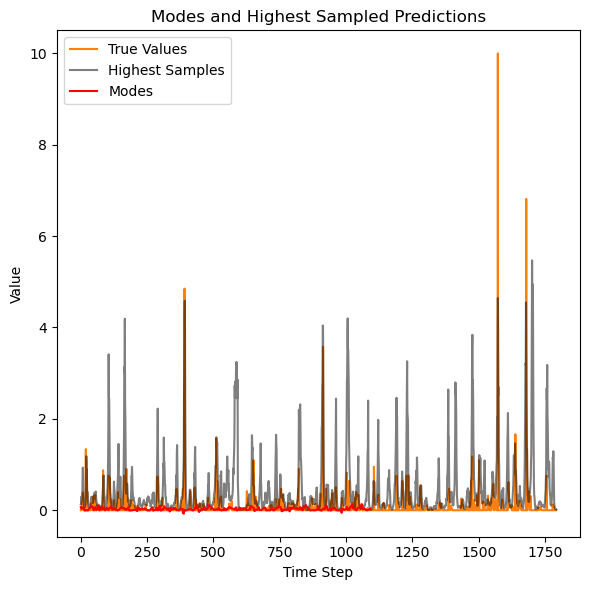

In [110]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))  # 1 row, 2 columns
# Second subplot: modes, highest samples, and true values
ax.plot(targets_test_np, label='True Values', color='C1')
ax.plot(highest_samples, label='Highest Samples', color='black', alpha=0.5)  
ax.plot(modes, label='Modes', color='red')  
ax.set_title('Modes and Highest Sampled Predictions')
ax.set_xlabel('Time Step')
ax.set_ylabel('Value')
ax.legend()
# axs[1].set_xlim(0, 300)

f.tight_layout()

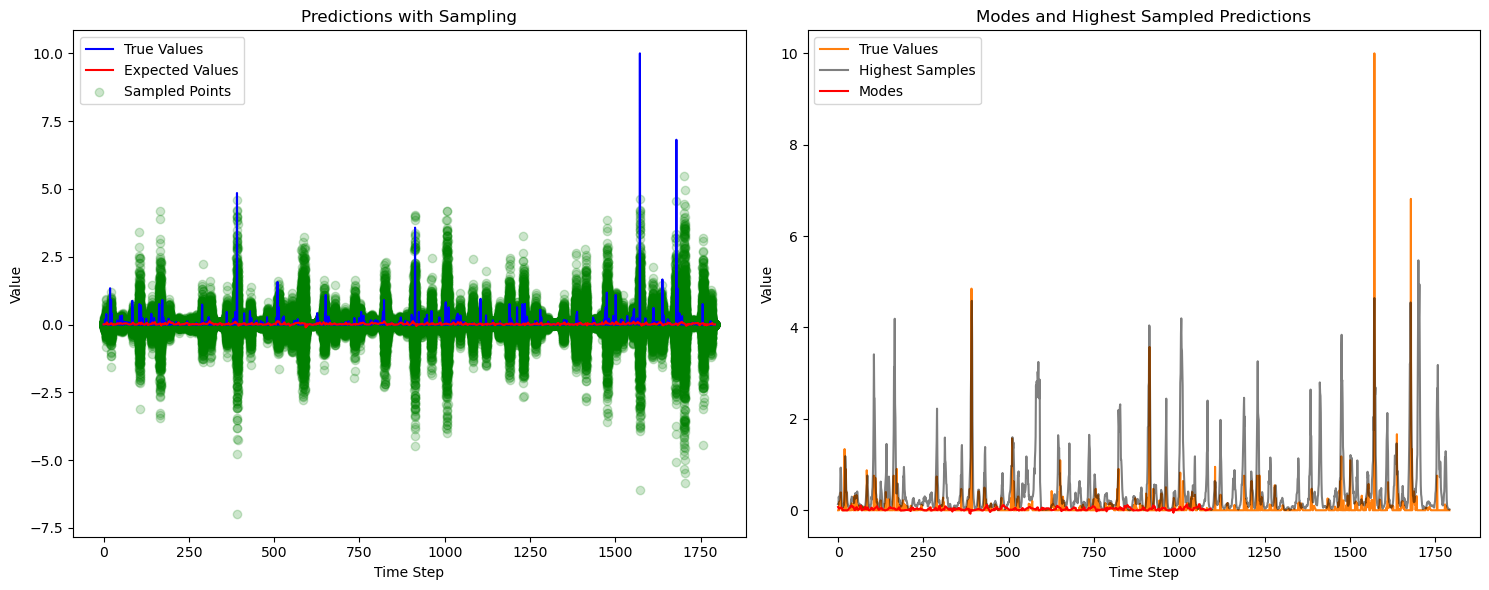

In [111]:
def visualize_combined_predictions(sampled_preds, expected_preds, true_vals, modes, highest_samples):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

    # First subplot: sampled predictions, expected predictions, and true values
    axs[0].plot(true_vals, label='True Values', color='blue')
    axs[0].plot(expected_preds, label='Expected Values', color='red')
    for i, val in enumerate(sampled_preds):
        axs[0].scatter([i] * len(val), val, alpha=0.2, color='green', label='Sampled Points' if i == 0 else "")
    
    # Adjusting the legend to avoid duplicate labels
    handles, labels = axs[0].get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    axs[0].legend(*zip(*unique))
    axs[0].set_title('Predictions with Sampling')
    axs[0].set_xlabel('Time Step')
    axs[0].set_ylabel('Value')
    # axs[0].set_xlim(0, 300)

    # Second subplot: modes, highest samples, and true values
    axs[1].plot(true_vals, label='True Values', color='C1')
    axs[1].plot(highest_samples, label='Highest Samples', color='black', alpha=0.5)  
    axs[1].plot(modes, label='Modes', color='red')  
    axs[1].set_title('Modes and Highest Sampled Predictions')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    # axs[1].set_xlim(0, 300)
    
    fig.tight_layout()
    


# # Visualize the predictions
visualize_combined_predictions(sampled_preds_test, expected_preds_test, targets_test_np, modes, highest_samples)

In [24]:
m = scale_data(max_values)

In [112]:
padding_length = len(test) - len(max_values)

# Pad zeros at the end of predicted_sample
predicted_sample_padded = np.pad(max_values, (0, padding_length), 'constant', constant_values=(0))

# Assign the padded array to your DataFrame
test['predicted_odor'] = predicted_sample_padded

In [113]:
test.loc[test['odor'] > 0, 'odor'] = 1
test.loc[test['predicted_odor'] > 0, 'predicted_odor'] = 1

In [114]:
# test['scaled_odor']=scale_data(test.odor)
query='odor>1'
df = test.query(query)
df.reset_index(drop=True, inplace=True)

query1='predicted_odor>1'
df1 = test.query(query1)
df1.reset_index(drop=True, inplace=True)

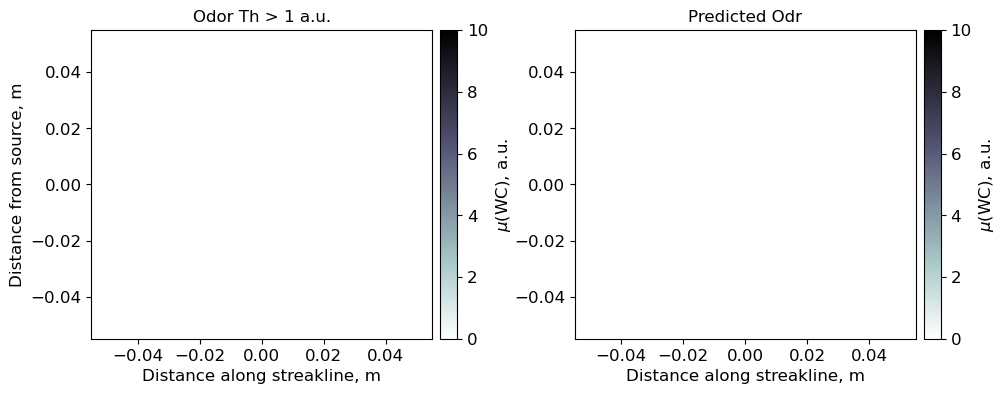

In [115]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
v = ax1.scatter(df.distance_along_streakline, df.nearest_from_streakline, c=df.odor, 
             s=10, cmap='bone_r', vmin=0,vmax=10)

ax1.set_title('Odor Th > 1 a.u.')
ax1.set_ylabel('Distance from source, m')
ax1.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(v, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

w = ax2.scatter(df1.distance_along_streakline, df1.nearest_from_streakline, c=df1.predicted_odor, 
             s=10, cmap='bone_r', vmin=0,vmax=10)

ax2.set_title('Predicted Odr')
# ax2.set_ylabel('Distance from source, m')
ax2.set_xlabel('Distance along streakline, m')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(w, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

f.tight_layout(pad=1)
mpl_functions.set_fontsize(f, 12)

In [143]:
x=pd.read_hdf('/home/beast/An/data/Sept13Plumes/plume1/train_raw/diag51.h5')
def calculate_distance_from_source(df):
    source = np.array([[0,0]])
    odor_position = np.array([[df.x[i],df.y[i]] for i in range (len(df))]) 

    distance_from_source = np.array([cdist(odor_position,source)]).flatten()
    df['distance_from_source'] = distance_from_source
    
    
calculate_distance_from_source(x)

In [144]:
test['distance_from_source']=x['distance_from_source']

In [147]:
osc.get_time_col(test,0.3)
# osc.calculate_distance_from_source(test)

In [148]:
test

,distance_along_streakline,nearest_from_streakline,odor,predicted_odor,distance_from_source,time
0,13.046484,-7.913884,0.0,0.100905,16.189688,0.0
1,13.303946,-9.069226,0.0,0.202242,14.072649,0.3
2,13.573563,-9.987976,0.0,0.209215,12.415922,0.6
3,13.846194,-10.636821,0.0,0.187955,11.201342,0.9
4,14.117726,-10.975016,0.0,0.346437,10.383462,1.2
...,...,...,...,...,...,...
1795,14.436371,10.289625,0.0,0.000000,15.784472,538.5
1796,15.362860,10.797050,0.0,0.000000,16.541840,538.8
1797,16.502294,10.982844,0.0,0.000000,16.902633,539.1
1798,17.876502,10.804456,0.0,0.000000,16.807442,539.4


In [153]:
def mean_conc(df,index,dat):
    #Distance
    i = 0
    mean_concentration = []
    while i<len(index):
        mean_concentration.append(np.mean(df.odor[index[i]])) 
        i+=1
    dat['mean_concentration']=mean_concentration

def cal_stat(df,index, index_predicted,fdf, fdf_predicted):
    osc.avg_distance(df,index,fdf)
    osc.whiff_blank_duration(df,index,fdf)
    mean_conc(df,index,fdf)
    
    osc.avg_distance(df,index_predicted,fdf_predicted)
    osc.whiff_blank_duration(df,index_predicted,fdf_predicted)
    
    osc.predicted_mean_conc(df,index_predicted,fdf_predicted)

np.seterr(divide='ignore')
index = osc.get_index(test.odor,0)
index_predicted = osc.get_index(test.predicted_odor,0)
fdf = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(test,index,index_predicted,fdf, fdf_predicted)

fdf.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'length_of_encounter', 'odor_intermittency', 'log_whiff', 'log_blank',
       'mean_concentration'],
      dtype='object')

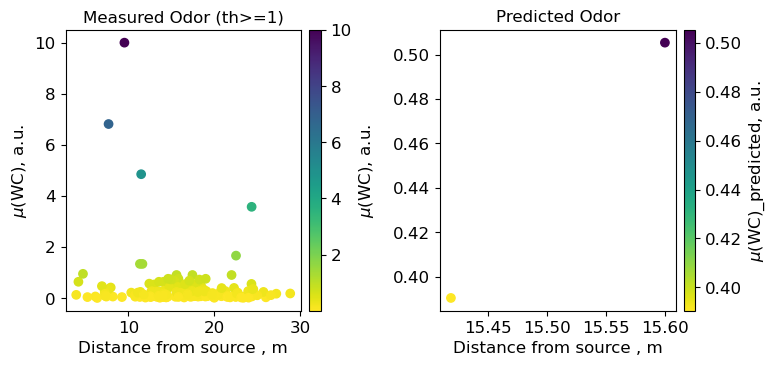

In [154]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.mean_concentration, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')
ax1.set_xlabel('Distance from source , m')
ax1.set_title('Measured Odor (th>=1)')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.mean_concentration_p, 
              c=fdf_predicted.mean_concentration_p, cmap='viridis_r' )
# ax2.set_ylabel('Whiff Concentration, a.u.')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

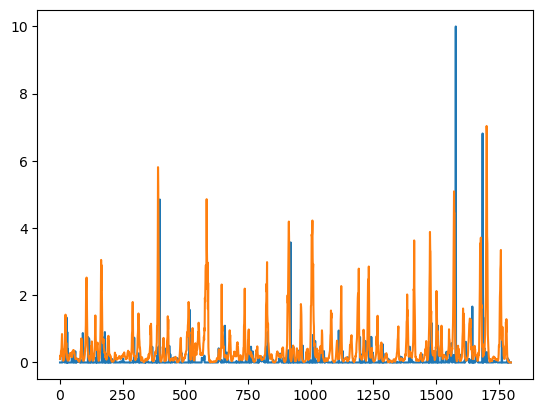

In [156]:
plt.plot(test.odor)
plt.plot(test.predicted_odor)